# Load libraries

In [1]:
import pandas as pd

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(readxl)
library(treemapify)
library(treemap)
library(tidyverse)
library(cowplot)
library(dplyr)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Load data

In [5]:
%%R -o best_hits
best_hits <- read_csv("data/best_hits_Touchon2020_2022.08.15.csv")

Rows: 7537 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The primary goal here is to understand the diversity of identified microcins in _E. coli_ genome assemblies. In this regard, we split assemblies into two classes:

2. Verified microcins 
   - These assemblies had a protein with the exact same sequence as the verified microcin sequences known in the literature
3. novel
   - These assemblies contained a match using BLAST and HMM to a verified microcin, though it is agnostic of how well the match is or any other components that were identified in the assembly.

What we will do is make a treemap to make two rectangles whose areas correspond to the number of assemblies that belong to each of these two groups. Verified and novel sequences zones contain various different protein sequences, and so will have sub rectangles whose areas correspond the amount of assemblies that had a given protein sequence.

## Data to be visualized
This contains, the sequence, unique identifier, whether or not it was verified.

In [6]:
%%R

n_genome <- best_hits %>%
    filter(component == "microcins.verified") %>%
    count(sample) %>%
    nrow()

n_put <- best_hits %>%
    filter(component == "microcins.verified") %>%
    count(pephash) %>%
    nrow()

print("Number of genomes with PUTATIVE microcins identified by Cinful:")
print(n_genome)

print("Number of unique peptides identified as microcins by Cinful:")
print(n_put)
#Number of putative microcins identified (no check for HMMer hits)


[1] "Number of genomes with PUTATIVE microcins identified by Cinful:"
[1] 313
[1] "Number of unique peptides identified as microcins by Cinful:"
[1] 101


In [7]:
%%R

count_of_hmmer_hits <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    count(sample) %>%
    nrow()


tot_uniq_hmmer_peptides <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    count(pephash) %>%
    nrow()

print("Number of TOTAL sample genomes with HMMer verified microcins:")
print(count_of_hmmer_hits)

print("Number of unique microcin sequences verified by HMMer:")
print(tot_uniq_hmmer_peptides)

#Number of genomes with microcins that pass HMMer

[1] "Number of TOTAL sample genomes with HMMer verified microcins:"
[1] 288
[1] "Number of unique microcin sequences verified by HMMer:"
[1] 64


In [8]:
%%R 

n_ver_genomes <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == TRUE) %>%
    count(sample) %>%
    nrow()

print("Number of sample genomes with KNOWN microcins:")
print(n_ver_genomes)

verified_microcin_peptides <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == TRUE) %>%
    count(pephash) %>%
    nrow()

print("Number of KNOWN microcins identified:")
print(verified_microcin_peptides)

[1] "Number of sample genomes with KNOWN microcins:"
[1] 211
[1] "Number of KNOWN microcins identified:"
[1] 6


In [10]:
%%R

n_unk_genomes <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == FALSE) %>%
    count(sample) %>%
    nrow()

print("Number of sample genomes with UNKNOWN microcins:")
print(n_unk_genomes)

n_unk_microcins <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == FALSE) %>%
    count(pephash) %>%
    nrow()

print("Number of UNKNOWN microcins identified:")
print(n_unk_microcins)


[1] "Number of sample genomes with UNKNOWN microcins:"
[1] 113
[1] "Number of UNKNOWN microcins identified:"
[1] 58


In [11]:
%%R
num_samples <- nrow(unique(best_hits[,"sample"]))

samples_wo_HMMER_microcins <- num_samples - as.integer(count_of_hmmer_hits)

print("Total genome assemblies analyzed:")
print(num_samples)
print("Samples with HMMER hits:")
print(count_of_hmmer_hits)
print("Samples without HMMER hits:")
print(samples_wo_HMMER_microcins)

[1] "Total genome assemblies analyzed:"
[1] 1224
[1] "Samples with HMMER hits:"
[1] 288
[1] "Samples without HMMER hits:"
[1] 936


In [12]:
%%R

#Total genomes with hmmer-verified microcins 
A <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    count(sample)
A
#288

#Total genomes with hmmer-verified microcins that are a 100% match to previously known microcins
B <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == TRUE) %>%
    count(sample)
B
#211

#Total genomes with hmmer-verified microcins that do not match previously known microcins (novel)
C <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == FALSE) %>%
    count(sample)
C
#113

#Total genomes with both previously known and novel microcins
inner_join(B[,1], C[,1], by = "sample")

print(nrow(A))
print(nrow(B))
print(nrow(C))
print(nrow(inner_join(B[,1], C[,1], by = "sample")))


#    write_csv("data/supplemental/count_of_6_verified_microcins.csv")

[1] 288
[1] 211
[1] 113
[1] 36


In [13]:
%%R
treemap_data <- best_hits %>%
	filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
	group_by(pephash,verified,sample,seq) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
#	add_row(pephash=NA, verified="no_microcin", n=samples_wo_microcins) %>%
	write_csv("data/supplemental/Ecoli_microcin_treemap_data.csv")

treemap_data

`summarise()` has grouped output by 'pephash', 'verified', 'sample'. You can
override using the `.groups` argument.
# A tibble: 365 × 5
   pephash                                           verified sample seq       n
   <chr>                                             <fct>    <chr>  <chr> <int>
 1 v1_PLS_030767dd6c0e5686eef2a8cbf65d305c761e4b8fc… FALSE    GCA_9… MREI…     1
 2 v1_PLS_030767dd6c0e5686eef2a8cbf65d305c761e4b8fc… FALSE    GCA_9… MREI…     1
 3 v1_PLS_0719676e795eaed3af7fb25fcc33805c9c4a26902… FALSE    GCA_9… ITLN…     1
 4 v1_PLS_162b4d1d19ac7e08ea0998616fd4a878ff9bbec04… FALSE    GCA_9… MRTL…     1
 5 v1_PLS_17d83a4d72fa714b8588985e84dc7828d8113227b… FALSE    GCA_9… YVFF…     1
 6 v1_PLS_1a8057dff938353b9638f6258b4cf9f4f34d47a3b… FALSE    GCA_9… MVKR…     1
 7 v1_PLS_1a8057dff938353b9638f6258b4cf9f4f34d47a3b… FALSE    GCA_9… MVKR…     1
 8 v1_PLS_1cddbead564a238a4068fa38deea45eb3eccc207d… FALSE    GCA_9… MASI…     1
 9 v1_PLS_2201698b4769e017fab30bcefc9e64ce3bb721713… F

## Treemap generation

`summarise()` has grouped output by 'pephash', 'verified'. You can override
using the `.groups` argument.


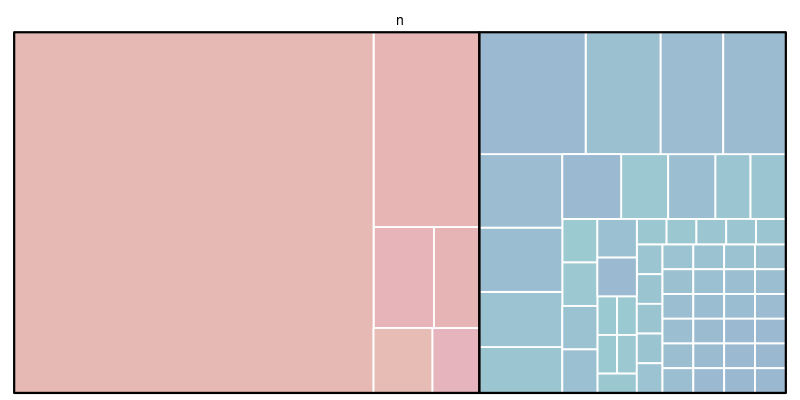

In [14]:
%%R -w 800 -h 400
best_hits_TM <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	group_by(pephash,verified,sample) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
#Uncomment row below to include all 1224 assemblies including those without HMM-verified microcin hits
#	add_row(pephash=NA, verified="no_microcin",n=samples_wo_microcins) %>% 
	treemap(
		index = c("verified","pephash"),
        vSize = "n",
		border.col=c("black","white"),
    	border.lwds=c(3,2.5),
		fontsize.labels=c(0,0),
		palette = c("#b6d9e8","#ffd1d1")
	)

# Uncomment below to save
#ggsave("plots/AF/03_Sankey_plot_FINAL.svg", width = 4, height = 2, units = c("in"))


# Data for table


In [15]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(verified == FALSE) %>%
	filter(hmmerHit == TRUE) %>%
	count(seq, sseqid, pident) %>%
	write_csv("data/supplemental/Ecoli_microcin_novel.csv")